In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
import random
import graphviz
import pydot



In [2]:
import tensorflow as tf 
from tensorflow.python.client import device_lib #GPU Check
import tensorflow.keras #keras
from tensorflow.keras import layers 
from tensorflow.keras import Sequential,Input,Model 
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Add, Activation, ZeroPadding2D,GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization,Conv2D, Conv3D,AveragePooling2D, MaxPooling2D, MaxPooling3D,GlobalMaxPooling2D, LeakyReLU  
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #use for early stopping and reduction on level-out
from tensorflow.keras.initializers import glorot_uniform, he_uniform #to initialize random weights for filters
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions, preprocess_input
from tensorflow.keras.models import Model, load_model  #Can't do much without a model
from tensorflow.keras import utils
from tensorflow.keras.utils import get_file, plot_model, to_categorical, model_to_dot
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50V2, MobileNetV2, VGG16, ResNet152, EfficientNetB6 as ENETB6
import tensorflow.keras.backend as K #let's write our own metrics and loss functions
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

# Import Data 

In [3]:
data_path = r'C:\Users\sohka\OneDrive\Documents\computer_vision\ImageData\training_images'
targets_path = r'C:\Users\sohka\OneDrive\Documents\computer_vision\ImageData\train_solution_bounding_boxes (1).csv'
data = []
targets = []
filename = []

In [5]:
df = pd.read_csv(targets_path)
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


# Parameters

In [6]:
for _, col in df.iterrows():
    #Get H,W
    img_path = os.path.join(data_path, col['image'])
    img = cv2.imread(img_path)
    (h,w) = img.shape[:2]

    #scale the bounding box coordinates to normalize
    startX = float(col['xmin'])/w
    startY = float(col['ymin'])/h

    endX = float(col['xmax'])/w
    endY = float(col['ymax'])/h

    #load the image and preprocess it 
    image = cv2.resize(img, (244,244))
    image = np.array(image)

    data.append(image)
    targets.append((startX,startY, endX, endY))
    filename.append(col['image'])
    



# Visualize Image
Create my own code


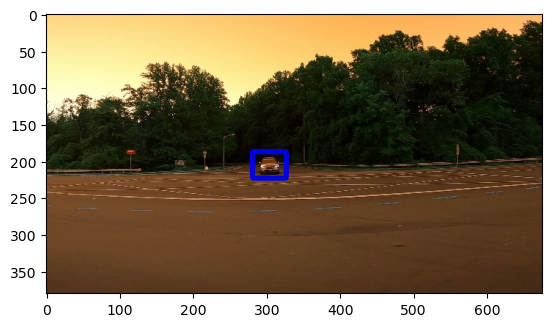

In [7]:
img_path = os.path.join(data_path, df['image'][0])
startX = int(targets[0][0] * w)
startY = int(targets[0][1] * h)
endX = int(targets[0][2] * w)
endY = int(targets[0][3] * h)
img = cv2.imread(img_path)
img = cv2.rectangle(img=img, pt1=(startX,startY), pt2=(endX,endY), color=(0,0,225),thickness=5)#place the rectangle on the image
plt.imshow(img)

Try the example code

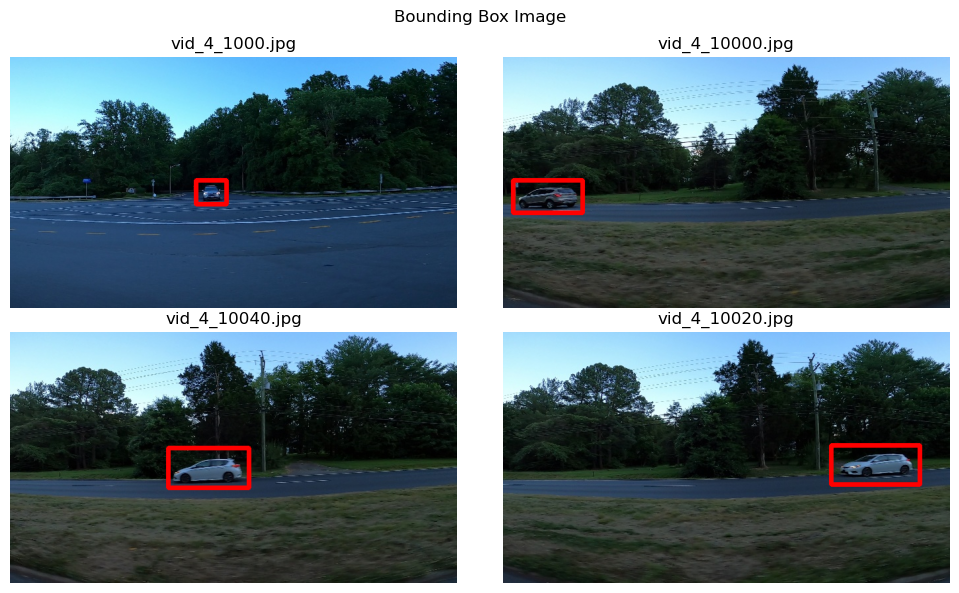

In [8]:
fig, axes = plt.subplots(2,2, figsize = (10,6))
fig.suptitle('Bounding Box Image')

for x, (name,target) in enumerate(zip(filename[:4], targets[:4])):
    #zip is for (('vid_4_1000.jpg',), ('vid_4_10000.jpg',), ('vid_4_10040.jpg',), ('vid_4_10020.jpg',), ('vid_4_10060.jpg',), ('vid_4_10100.jpg',), ('vid_4_10120.jpg',), ('vid_4_10140.jpg',))
    file_path = os.path.join(data_path, name)
    img = cv2.imread(file_path)
    img_draw = img
    (h,w) = img.shape[:2]

    startX = int(target[0] * w)#locate the red box
    startY = int(target[1] * h)
    endX = int(target[2] * w)
    endY = int(target[3] * h)

    cv2.rectangle(img= img_draw, pt1=(startX, startY), pt2=(endX, endY), color=(0,0,255), thickness=5)
    axes[x // 2, x % 2].set_title(f'{name}')
    axes[x // 2, x % 2].imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
    axes[x // 2, x % 2].axis('off')
plt.tight_layout()
plt.show()

# Change the pixel intensities from [0,255] to [0,1]

In [9]:
# pixel intensities from the range [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
targets = np.array(targets, dtype="float32")

# Train Test Split

In [10]:
split = train_test_split(data, targets, filename, test_size=0.20,random_state=88)
(trainImages, valImages) = split[:2]
(trainTargets, valTargets) = split[2:4]
(trainFilenames, valFilenames) = split[4:]

From my understanding, YOLO architecture has overall 24 convolutional layers, four max-pooling layers, and two fully connected layers. I am trying to  create these layers according to a paper written about YOLO structure  to  to try on the data. 

In [12]:
#The first layer with maxpooling
input_layer = Input(shape=(244,244,3))
model = input_layer
model = Conv2D( 64,(3,3), activation='relu', strides=2, padding='same')(model)
model = MaxPooling2D(pool_size=(2,2), strides=2, padding='same')(model)

#The first layer with maxpooling
model = Conv2D(192,(3,3), activation="relu",padding='same')(model)
model = MaxPooling2D(pool_size=(2,2), strides=2,padding='same')(model)

#The first layer with maxpooling
model = Conv2D(128,(1,1), activation="relu",padding='same')(model)
model = Conv2D(256,(3,3), activation="relu",padding='same')(model)
model = Conv2D(256,(1,1), activation="relu",padding='same')(model)
model = Conv2D(512,(3,3), activation="relu",padding='same')(model)
model = MaxPooling2D((2,2), strides=2,padding='same')(model)

#The first layer with maxpooling
model = Conv2D(256,(1,1), activation="relu",padding='same')(model)
model = Conv2D(512,(3,3), activation="relu",padding='same')(model)
model = Conv2D(256,(1,1), activation="relu",padding='same')(model)
model = Conv2D(512,(3,3), activation="relu",padding='same')(model)
model = Conv2D(256,(1,1), activation="relu",padding='same')(model)
model = Conv2D(512,(3,3), activation="relu",padding='same')(model)
model = Conv2D(256,(1,1), activation="relu",padding='same')(model)
model = Conv2D(512,(3,3), activation="relu",padding='same')(model)
model = Conv2D(512,(1,1), activation="relu",padding='same')(model)
model = Conv2D(1024,(3,3), activation="relu",padding='same')(model)
model = MaxPooling2D((2,2), strides=2,padding='same')(model)

#The first layer with maxpooling
model = Conv2D(512,(1,1), activation="relu",padding='same')(model)
model = Conv2D(1024,(3,3), activation="relu",padding='same')(model)
model = Conv2D(512,(1,1), activation="relu",padding='same')(model)
model = Conv2D(1024,(3,3), activation="relu",padding='same')(model)
model = Conv2D(1024,(3,3), activation="relu",padding='same')(model)
model = Conv2D(1024,(3,3), strides=2, padding='same')(model)

#The last two conv layer without max pooling, I couldn't run due to the size of input 
model = Conv2D(1024,(3,3), activation="relu", padding='same')(model)
model = Conv2D(1024,(3,3), activation="relu")(model)

#Two connect layer 
model = Flatten()(model)
model = Dense(256, activation="relu")(model)
model = Dense(64, activation="relu")(model)
model = Dense(32, activation="relu")(model)
output = Dense(4, activation="sigmoid")(model)
#softmax is suitable for this as it lowers the validation loss 


model1 = Model(inputs=input_layer, outputs=output)
model1.summary()












Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 122, 122, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 192)       110784    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 192)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       24704 

# Compile model

In [13]:
with tf.device('/GPU:0'):
    model1.compile(optimizer='adam',loss='mse')


In [14]:
#train model
history1 = model1.fit(trainImages, trainTargets, validation_data=(valImages, valTargets),
                    batch_size=32, epochs=20, verbose=1)


Epoch 1/20
14/14 [==============================] - 28s 982ms/step - loss: 0.0619 - val_loss: 0.0449
Epoch 2/20
14/14 [==============================] - 3s 207ms/step - loss: 0.0506 - val_loss: 0.0441
Epoch 3/20
14/14 [==============================] - 3s 207ms/step - loss: 0.0502 - val_loss: 0.0442
Epoch 4/20
14/14 [==============================] - 3s 207ms/step - loss: 0.0507 - val_loss: 0.0442
Epoch 5/20
14/14 [==============================] - 3s 208ms/step - loss: 0.0502 - val_loss: 0.0442
Epoch 6/20
14/14 [==============================] - 3s 207ms/step - loss: 0.0505 - val_loss: 0.0449
Epoch 7/20
14/14 [==============================] - 3s 206ms/step - loss: 0.0505 - val_loss: 0.0442
Epoch 8/20
14/14 [==============================] - 3s 206ms/step - loss: 0.0503 - val_loss: 0.0442
Epoch 9/20
14/14 [==============================] - 3s 204ms/step - loss: 0.0504 - val_loss: 0.0442
Epoch 10/20
14/14 [==============================] - 3s 204ms/step - loss: 0.0502 - val_loss: 0.044

# Visualize training and validation results

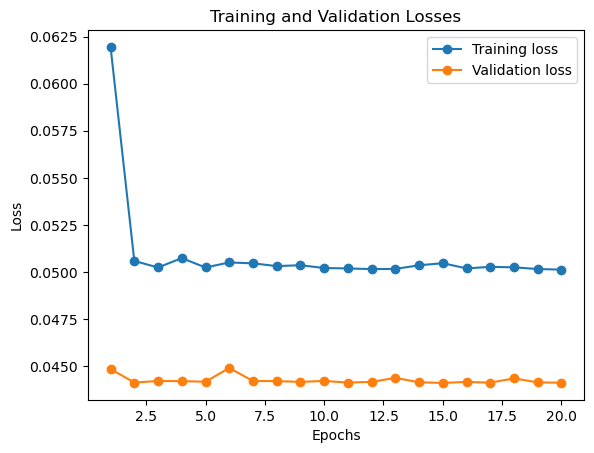

In [15]:
# Get the training and validation losses from the history object
train_loss = history1.history['loss']
val_loss = history1.history['val_loss']

# Create an array representing the number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation losses
plt.plot(epochs, train_loss,label='Training loss', marker='o')
plt.plot(epochs, val_loss,label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

ACCURACY - IOU (INTERESECTION OF UNION ) ALGORITHM

In [16]:

def IoU(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])
    
    # Calculate Intersection Area
    inter_area = (y2_inter - y1_inter) * (x2_inter - x1_inter)
    
    # Calculate Uninon Area:
    box1_area = (box1[3] - box1[1]) * (box1[2] - box1[0])
    box2_area = (box2[3] - box2[1]) * (box2[2] - box2[0])
    union_area = box1_area + box2_area - inter_area
    
    IoU = inter_area/union_area
    
    return abs(IoU)

Accuracy List 

In [17]:
acc_list = []

for _, col in df.iterrows():
    img_path = os.path.join(data_path, col['image'])
    image = cv2.imread(img_path)
    image = cv2.resize(image, (244, 244))
    image = np.array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    preds = model1.predict(image)[0]
    box1 = preds
    
    img = cv2.imread(img_path)
    img = cv2.resize(img, (244, 244))
    (h, w) = img.shape[:2]
    
    # scale the bounding box coordinates 
    startX = float(col['xmin']) / w
    startY = float(col['ymin']) / h
    endX = float(col['xmax']) / w
    endY = float(col['ymax']) / h
    
    box2 = [startX, startY, endX, endY]
    
    acc_list.append(IoU(box1, box2))

1/1 [==============================] - 0s 18ms/step


# Predict

In [18]:
test_path = r"C:\Users\sohka\OneDrive\Documents\computer_vision\ImageData\testing_images"


# Visualize predicted result

1/1 [==============================] - 1s 641ms/step


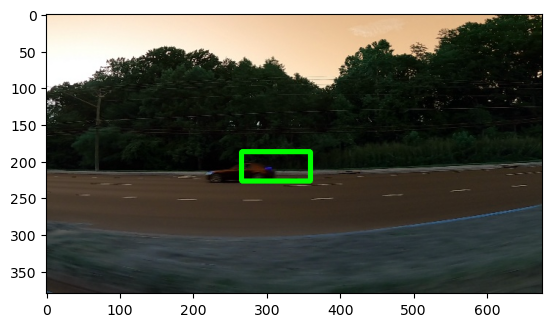

1/1 [==============================] - 0s 21ms/step


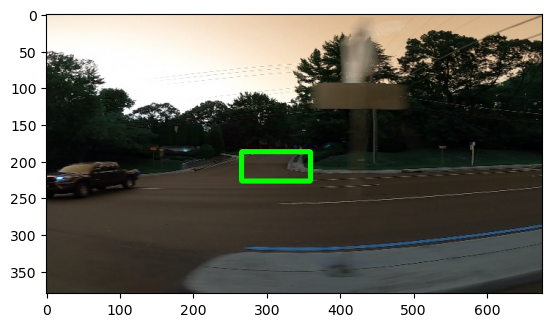

1/1 [==============================] - 0s 23ms/step


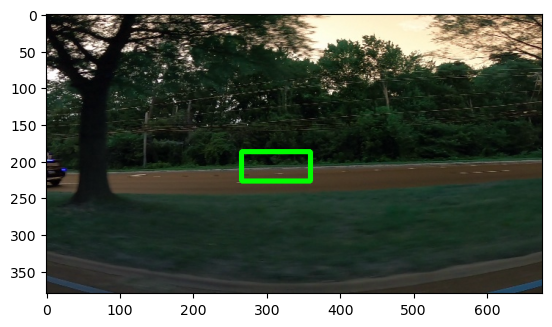

1/1 [==============================] - 0s 22ms/step


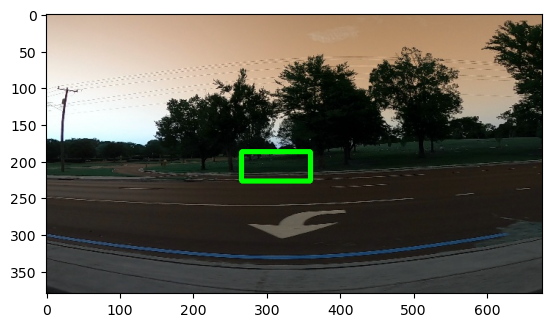

1/1 [==============================] - 0s 20ms/step


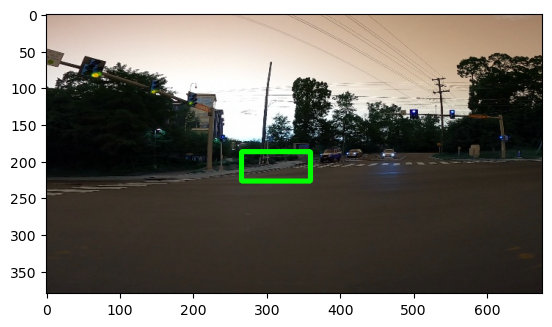

1/1 [==============================] - 0s 32ms/step


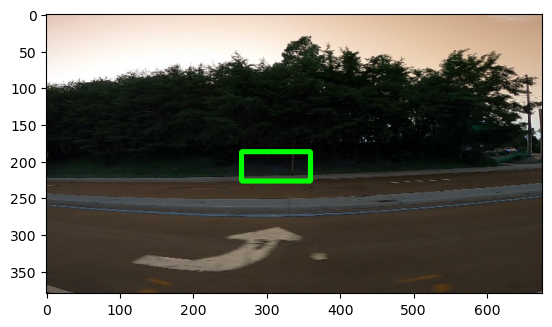

1/1 [==============================] - 0s 21ms/step


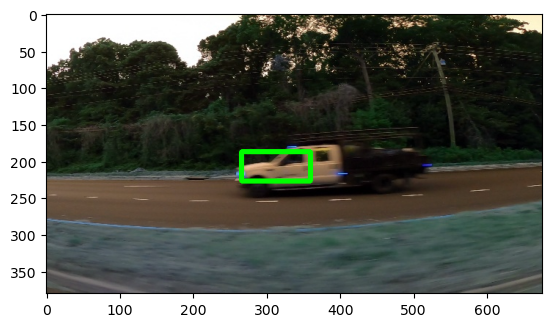

1/1 [==============================] - 0s 25ms/step


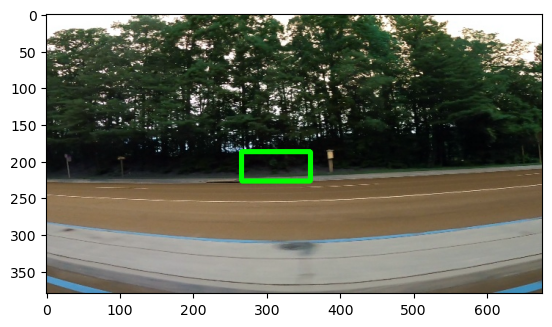

1/1 [==============================] - 0s 36ms/step


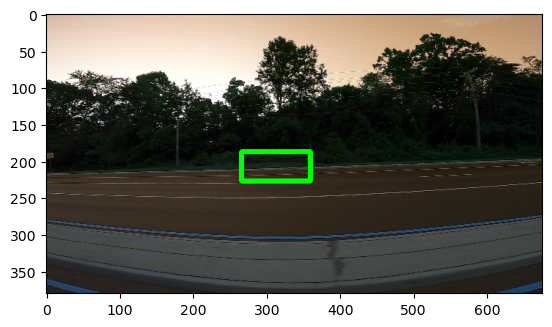

1/1 [==============================] - 0s 24ms/step


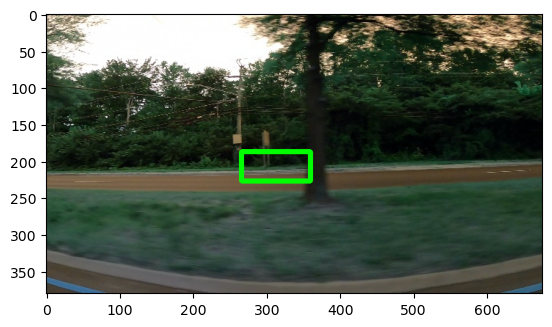

In [19]:
NUM_FILE = 10 # get 5 files to predict

for img in random.sample(os.listdir(test_path), NUM_FILE):
    img_path = os.path.join(test_path, img)
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    image = np.expand_dims(image, axis=0)
    
    preds = model1.predict(image)[0]
    (startX, startY, endX, endY) = preds
    
    img = cv2.imread(img_path)
    (h, w) = img.shape[:2]
    
    startX = int(startX * w)
    startY = int(startY * h)
    endX = int(endX * w)
    endY = int(endY * h)
    
    img_draw = img.copy()
    cv2.rectangle(img_draw, (startX, startY), (endX, endY), (0, 255, 0), 5)
    plt.imshow(img_draw)
    
    plt.show()


